In [ ]:
!pip install pandas numpy scipy matplotlib scikit-learn



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install openpyxl


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Importation of the libraries

import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy.stats import linregress
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [4]:
# Define variables
# Importation variables
file_path = 'C:/Users/arnou/Documents/thesis/Resultaten/250905_plate4xyloseA2_H2Sheet1.xlsx' #'Z:/SET-MPM-B001/PI-SG-021/Bart Steemans/Stationary Phase Project/SGL758 16092024 .xlsx' # Replace with the path to reach the excel file. Mind the /
sheet_name = 'Table All Cycles' # Replace with the name of the excel sheet containing the raw data
skiprows = 12 # Define the number of rows to skip in the excel file to reach the headers row (e.g. : 13 if the row containing the samples names is the row 14 of the Excel file)
nrows = 302 # Number of rows to read in the excel file. Includes the headers row
columns_range = 'B:CT'  # Replace with the desired cell range. Should cover the time values and the OD values
time_format = 'XX h XX min' # Define the format of the Time values. Choose between : 'XX h XX min' ; 'decimal hour' ; 'minutes' ('decimal hour' : 30min is expressed as 0,5)

# Sample to use as an example to plot at every step.
sample_to_plot = 'Sample X1' # Replace with the name of the sample to plot. Should be the same as the name of the sample in the excel file

# Smoothing variable
window_size = 6 # Window size for the Savitzky–Golay smoothing algorithm 

# Variable for the determination of the best linear regression fit
window_regression = 25 # Size of the sliding window for the calculation of the "exponential phase candidates"

# Exportation file 
#export_path = 'L:/SET-MPM-B001/PI-SG-021/Alix Meunier/Growth curves/Python pipeline/third_test.csv'


In [5]:
# Read the Excel file, specifying that the first two rows are headers

df = pd.read_excel(file_path, sheet_name=sheet_name, header= [0,1], index_col=None, skiprows=skiprows, nrows=nrows) 

# Flatten the MultiIndex columns to just use the top header (A01, A02, etc.)
df.columns = [col[0] for col in df.columns]
df.columns.values[1] = "Time"
columns_to_keep = df.columns[1:]  # for example, slice columns 3-5
df = df[columns_to_keep]

# Now you have: Time, A01, A02, ..., A06
print(df.head())

df_melted = pd.melt(df, id_vars='Time', var_name='Sample', value_name='OD')

# Print the resulting DataFrame
print(df_melted)

         Time    A01    A02    A03    A04    A05    A06    A07    A08    A09  \
0        0 h   0.085  0.085  0.082  0.084  0.083  0.081  0.083  0.082  0.082   
1   0 h 5 min  0.085  0.095  0.084  0.084  0.083  0.082  0.082  0.083  0.083   
2  0 h 10 min  0.085  0.086  0.084  0.084  0.083  0.083  0.083  0.083  0.082   
3  0 h 15 min  0.085  0.085  0.084  0.083  0.083  0.083  0.083  0.083  0.082   
4  0 h 20 min  0.086  0.085  0.085  0.084  0.083  0.081  0.083  0.084  0.082   

   ...    H03    H04    H05    H06    H07    H08    H09    H10    H11    H12  
0  ...  0.083  0.085  0.083  0.083  0.083  0.082  0.083  0.085  0.087  0.087  
1  ...  0.084  0.087  0.083  0.084  0.084  0.083  0.084  0.084  0.088  0.088  
2  ...  0.086  0.086  0.084  0.084  0.082  0.083  0.084  0.086  0.087  0.087  
3  ...  0.085  0.085  0.083  0.084  0.084  0.084  0.083  0.087  0.089  0.087  
4  ...  0.085  0.085  0.084  0.085  0.084  0.083  0.083  0.085  0.086  0.089  

[5 rows x 97 columns]
              Time Sam

In [6]:
def convert_time_to_minutes(time_str):
    if pd.isna(time_str):
        return pd.NA
    
    try:
        time_str = str(time_str)  # Ensure we are working with a string
        if ' min' in time_str:
            hours, minutes = time_str.split(' h ')
            minutes = int(minutes.replace(' min', ''))
        else:
            hours = int(time_str.replace(' h', ''))
            minutes = 0
        hours = int(hours)
        return hours * 60 + minutes
    except ValueError:
        return pd.NA  # Return NaN if the format is unexpected

# Apply the function
df_melted['Time'] = df_melted['Time'].apply(convert_time_to_minutes)
print(df_melted)


       Time Sample     OD
0         0    A01  0.085
1         5    A01  0.085
2        10    A01  0.085
3        15    A01  0.085
4        20    A01  0.086
...     ...    ...    ...
27643  1428    H12  1.133
27644  1433    H12  1.169
27645  1438    H12  1.115
27646  1443    H12  1.183
27647  1448    H12  1.135

[27648 rows x 3 columns]


In [ ]:
#metadata 
file_path = 'C:/Users/arnou/Documents/thesis/Resultaten/gross_lab_bsubtilis_crispri_kd.xlsx' #'Z:/SET-MPM-B001/PI-SG-021/Bart Steemans/Stationary Phase Project/SGL758 16092024 .xlsx' # Replace with the path to reach the excel file. Mind the /
sheet_name = 'xylosetestA2_H2'
df_meta = pd.read_excel(file_path, sheet_name=sheet_name, header= 0,index_col=None) 
print(df_meta)

   MetaData_Plaat MetaData_Well  \
0         Plate_4           A01   
1         Plate_4           A02   
2         Plate_4           A03   
3         Plate_4           A04   
4         Plate_4           A05   
..            ...           ...   
91        Plate_4           H08   
92        Plate_4           H09   
93        Plate_4           H10   
94        Plate_4           H11   
95        Plate_4           H12   

                                       MetaData_gene  MetaData_xyloseconc  \
0          Strain name:  BEC01390; Gene target: infA                0.005   
1          Strain name:  BEC01390; Gene target: infA                0.005   
2          Strain name:  BEC01390; Gene target: infA                0.005   
3          Strain name:  BEC01390; Gene target: infA                0.005   
4          Strain name:  BEC01390; Gene target: infA                0.010   
..                                               ...                  ...   
91  Strain name:  CAG74399_84; Gene targ

In [ ]:
#merge metadata

df_merged = df_melted.merge(
    df_meta,
    left_on="Sample",         # wells like A01 in your main data
    right_on="MetaData_Well", # wells like A01 in metadata
    how="left"
)

# Rename columns: keep "Well" for the plate position, "Sample" for the gene knockout
df_merged = df_merged.rename(columns={
    "Sample": "Well",
    "MetaData_gene": "Sample"
})

print(df_merged)

df_melted =df_merged       

       Time Well     OD MetaData_Plaat MetaData_Well  \
0         0  A01  0.085        Plate_4           A01   
1         5  A01  0.085        Plate_4           A01   
2        10  A01  0.085        Plate_4           A01   
3        15  A01  0.085        Plate_4           A01   
4        20  A01  0.086        Plate_4           A01   
...     ...  ...    ...            ...           ...   
27643  1428  H12  1.133        Plate_4           H12   
27644  1433  H12  1.169        Plate_4           H12   
27645  1438  H12  1.115        Plate_4           H12   
27646  1443  H12  1.183        Plate_4           H12   
27647  1448  H12  1.135        Plate_4           H12   

                                                 Sample  MetaData_xyloseconc  \
0             Strain name:  BEC01390; Gene target: infA                0.005   
1             Strain name:  BEC01390; Gene target: infA                0.005   
2             Strain name:  BEC01390; Gene target: infA                0.005   
3      

In [9]:
# --- 1. Create unique identifier column ---
df_merged["Unique_ID"] = (
    df_merged["Sample"].str.extract(r"Strain name:\s*(.*?);")[0] + " | " +
    df_merged["MetaData_xyloseconc"].astype(str) + "% xylose | " +
    df_merged["MetaData_xylosehour"].astype(str)
)
print(df_merged)

       Time Well     OD MetaData_Plaat MetaData_Well  \
0         0  A01  0.085        Plate_4           A01   
1         5  A01  0.085        Plate_4           A01   
2        10  A01  0.085        Plate_4           A01   
3        15  A01  0.085        Plate_4           A01   
4        20  A01  0.086        Plate_4           A01   
...     ...  ...    ...            ...           ...   
27643  1428  H12  1.133        Plate_4           H12   
27644  1433  H12  1.169        Plate_4           H12   
27645  1438  H12  1.115        Plate_4           H12   
27646  1443  H12  1.183        Plate_4           H12   
27647  1448  H12  1.135        Plate_4           H12   

                                                 Sample  MetaData_xyloseconc  \
0             Strain name:  BEC01390; Gene target: infA                0.005   
1             Strain name:  BEC01390; Gene target: infA                0.005   
2             Strain name:  BEC01390; Gene target: infA                0.005   
3      

In [10]:
# Blank correction (average of first 15 minutes)

# Filter the DataFrame for 'Time' values between 0 and 15 minutes
filtered_df = df_merged[(df_merged['Time'] >= 0) & (df_merged['Time'] <= 15)]

# Calculate the average OD for each 'Sample' group
average_blank_persample = filtered_df.groupby('Well')['OD'].mean()

# Add a new column 'Blank_value' to df_merged
df_merged['Blank_value'] = df_merged['Well'].map(average_blank_persample)

print("Blank values (average of 0–15 min) for each sample:")
print(average_blank_persample)
print('-' * 80)

# Subtract the blank values
df_blank_subs = df_merged.copy()
df_blank_subs['OD_Blank_Sub'] = df_merged['OD'] - df_merged['Blank_value']


#voor vervolg van code is het gemakkleijekr als tijd in uur stat
df_blank_subs['Time'] = df_blank_subs['Time'] / 60
# Print the updated DataFrame
print(df_blank_subs)

# Count the negative values
negative_values_count = (df_blank_subs['OD_Blank_Sub'] < 0).sum()
print(f"Number of negative, blank subtracted OD values : {negative_values_count}")



Blank values (average of 0–15 min) for each sample:
Well
A01    0.08500
A02    0.08775
A03    0.08350
A04    0.08375
A05    0.08300
        ...   
H08    0.08300
H09    0.08350
H10    0.08550
H11    0.08775
H12    0.08725
Name: OD, Length: 96, dtype: float64
--------------------------------------------------------------------------------
            Time Well     OD MetaData_Plaat MetaData_Well  \
0       0.000000  A01  0.085        Plate_4           A01   
1       0.083333  A01  0.085        Plate_4           A01   
2       0.166667  A01  0.085        Plate_4           A01   
3       0.250000  A01  0.085        Plate_4           A01   
4       0.333333  A01  0.086        Plate_4           A01   
...          ...  ...    ...            ...           ...   
27643  23.800000  H12  1.133        Plate_4           H12   
27644  23.883333  H12  1.169        Plate_4           H12   
27645  23.966667  H12  1.115        Plate_4           H12   
27646  24.050000  H12  1.183        Plate_4       

C:\Users\arnou\AppData\Local\Temp\ipykernel_19920\1448254367.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap('viridis')


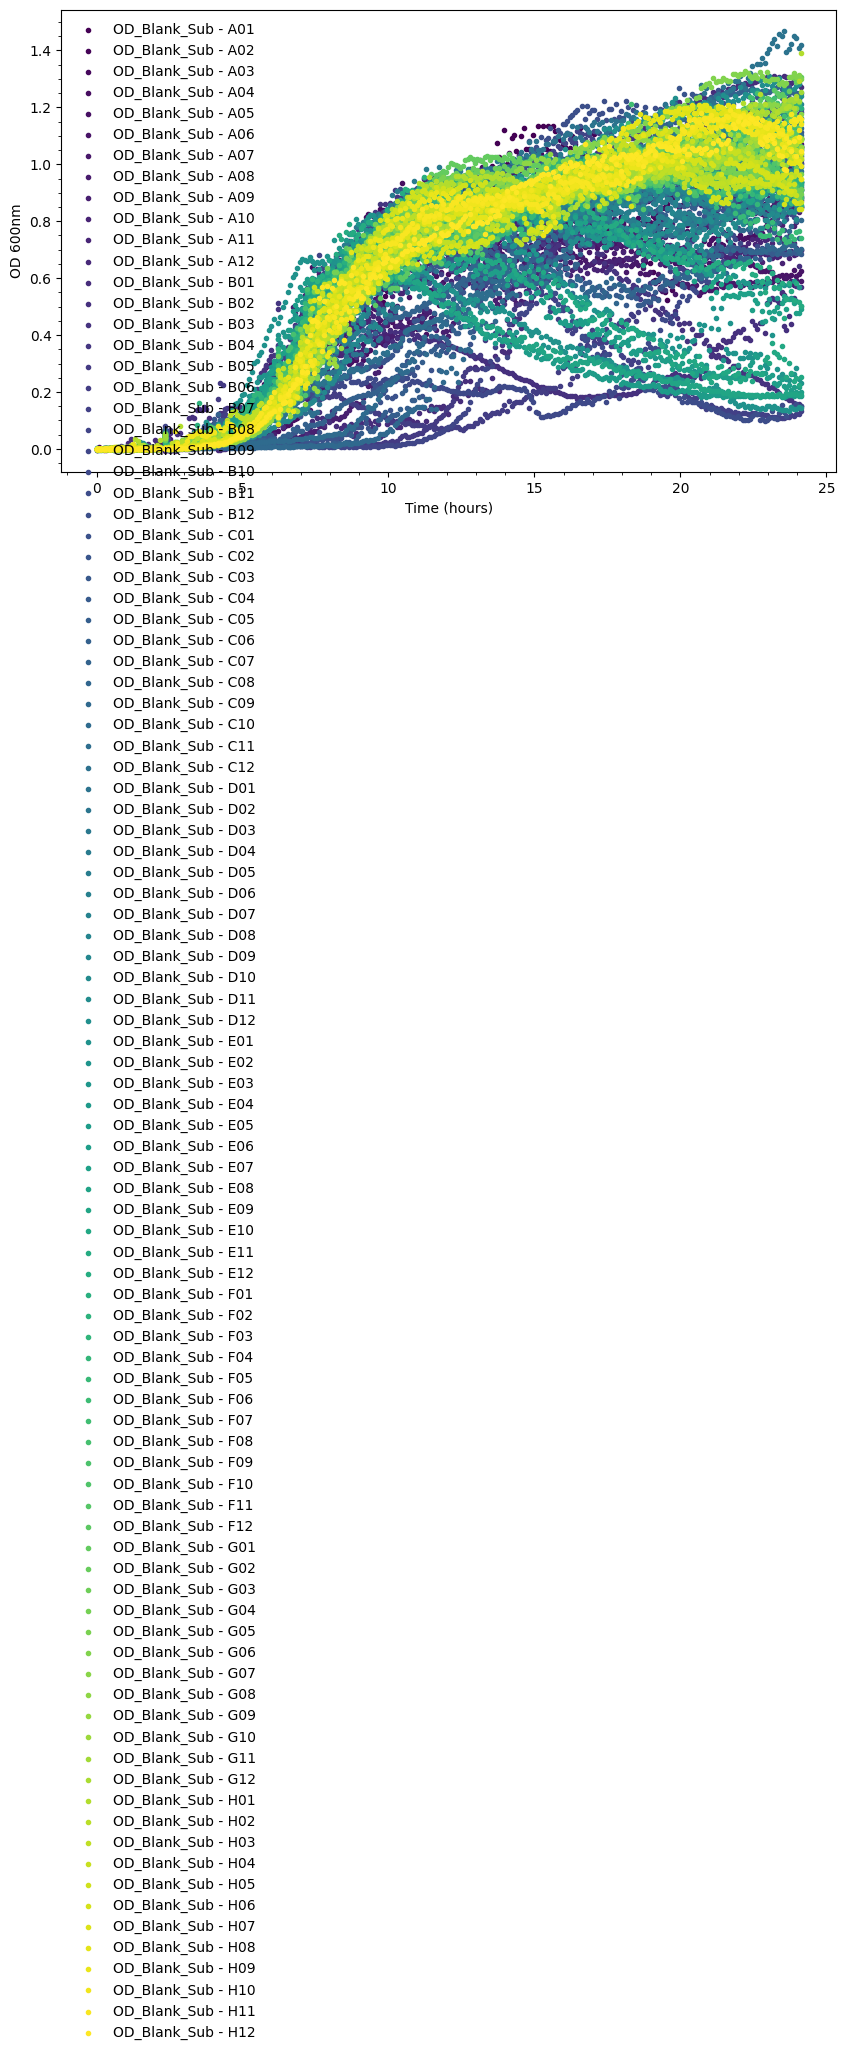

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.ticker import AutoMinorLocator

# Get unique sample IDs automatically
samples = df_blank_subs['Well'].unique()

fig, ax = plt.subplots(figsize=(10, 6))

# Define a colormap
colormap = get_cmap('viridis')
colors = colormap(np.linspace(0, 1, len(samples)))

# Plot each sample
for index, sample_to_plot in enumerate(samples):
    sample_data = df_blank_subs[df_blank_subs['Well'] == sample_to_plot]
    ax.scatter(
        sample_data['Time'],
        sample_data['OD_Blank_Sub'],
        marker='.',
        label=f'OD_Blank_Sub - {sample_to_plot}',
        color=colors[index]
    )

# Add vertical lines at given hours
#hours = [10, 12, 16, 18, 20, 24, 26, 28, 48]
#for hour in hours:
    #ax.axvline(x=hour, color='grey', linestyle='--', linewidth=1)

# Labels and ticks
ax.set_xlabel('Time (hours)')
ax.set_ylabel('OD 600nm')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# Let matplotlib automatically build the legend from labels
ax.legend(frameon=False)
#ax.set_xlim(0, 12) #eerste 12 uur enkel bekijken
#ax.set_ylim(0, 1.5)
plt.show()


In [12]:
# Smoothing function with Spline
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline

# Example spline smoothing function
def apply_spline(group, smoothing_factor=0.5):
    """
    Apply spline smoothing to OD values for each group.
    - smoothing_factor: Controls how smooth the spline is.
                        If None, spline will interpolate exactly through points.
    """
    x = group['Time'].values
    y = group['OD'].values
    
    # Fit spline
    spline = UnivariateSpline(x, y, s=smoothing_factor)
    
    # Apply smoothing
    smoothed_OD = spline(x)
    
    # Store results
    group['Smoothed_OD'] = smoothed_OD
    return group

# Apply per 'MetaData_Well' like before
df_smoothed = df_blank_subs.groupby('Well').apply(
    apply_spline, smoothing_factor=0.5  # Adjust smoothing factor
)

# Reset index
df_smoothed = df_smoothed.reset_index(drop=True)



print(df_smoothed)




            Time Well     OD MetaData_Plaat MetaData_Well  \
0       0.000000  A01  0.085        Plate_4           A01   
1       0.083333  A01  0.085        Plate_4           A01   
2       0.166667  A01  0.085        Plate_4           A01   
3       0.250000  A01  0.085        Plate_4           A01   
4       0.333333  A01  0.086        Plate_4           A01   
...          ...  ...    ...            ...           ...   
27643  23.800000  H12  1.133        Plate_4           H12   
27644  23.883333  H12  1.169        Plate_4           H12   
27645  23.966667  H12  1.115        Plate_4           H12   
27646  24.050000  H12  1.183        Plate_4           H12   
27647  24.133333  H12  1.135        Plate_4           H12   

                                                 Sample  MetaData_xyloseconc  \
0             Strain name:  BEC01390; Gene target: infA                0.005   
1             Strain name:  BEC01390; Gene target: infA                0.005   
2             Strain name: 

C:\Users\arnou\AppData\Local\Temp\ipykernel_19920\652036029.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_smoothed = df_blank_subs.groupby('Well').apply(


C:\Users\arnou\AppData\Local\Temp\ipykernel_19920\30338029.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap('viridis')


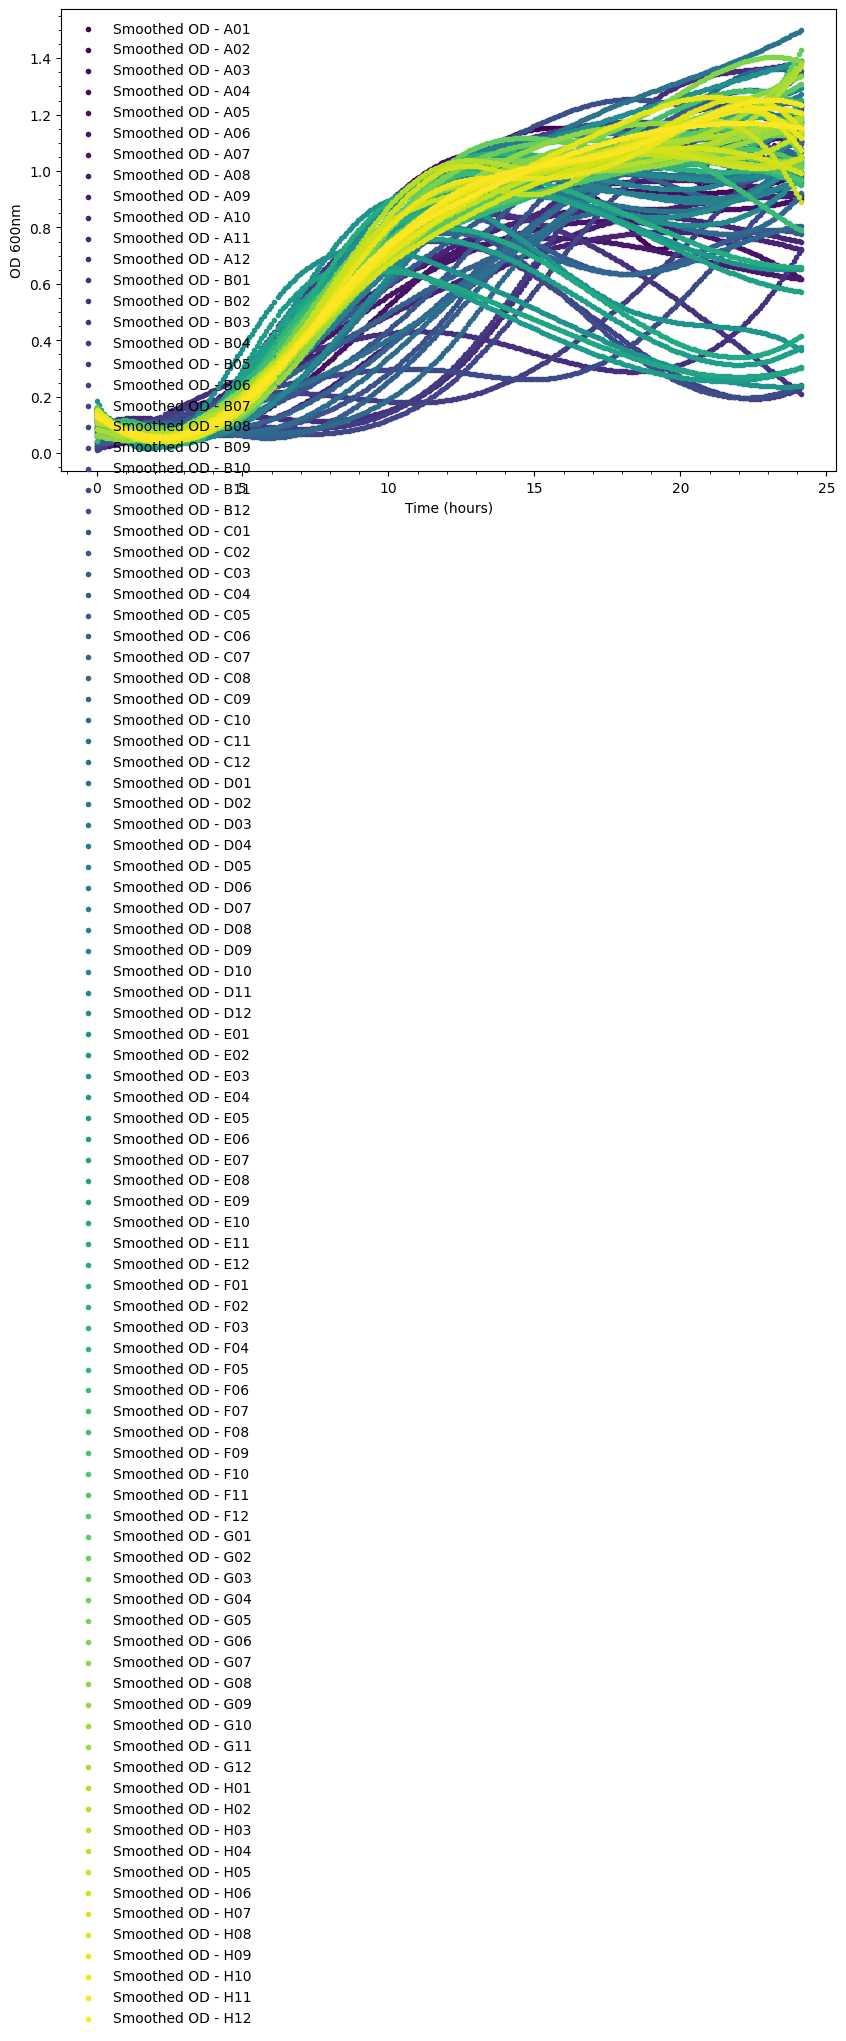

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.ticker import AutoMinorLocator

# Get unique sample IDs automatically
samples = df_smoothed['Well'].unique()

fig, ax = plt.subplots(figsize=(10, 6))

# Define a colormap
colormap = get_cmap('viridis')
colors = colormap(np.linspace(0, 1, len(samples)))

# Plot each sample
for index, sample_to_plot in enumerate(samples):
    sample_data = df_smoothed[df_smoothed['Well'] == sample_to_plot]
    ax.scatter(
        sample_data['Time'],
        sample_data['Smoothed_OD'],
        marker='.',
        label=f'Smoothed OD - {sample_to_plot}',
        color=colors[index]
    )

# Add vertical lines at given hours
#hours = [10, 12, 16, 18, 20, 24, 26, 28, 48]
#for hour in hours:
    #ax.axvline(x=hour, color='grey', linestyle='--', linewidth=1)

# Labels and ticks
ax.set_xlabel('Time (hours)')
ax.set_ylabel('OD 600nm')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# Let matplotlib automatically build the legend from labels
ax.legend(frameon=False)
#ax.set_xlim(0, 12) #eerste 12 uur enkel bekijken
#ax.set_ylim(0, 1.5)
plt.show()


C:\Users\arnou\AppData\Local\Temp\ipykernel_19920\1250486089.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_blue = get_cmap("Blues")
C:\Users\arnou\AppData\Local\Temp\ipykernel_19920\1250486089.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_yellow = get_cmap("YlOrBr")


Saved plot as: Strain_name_BEC01390_Gene_target_infA.svg


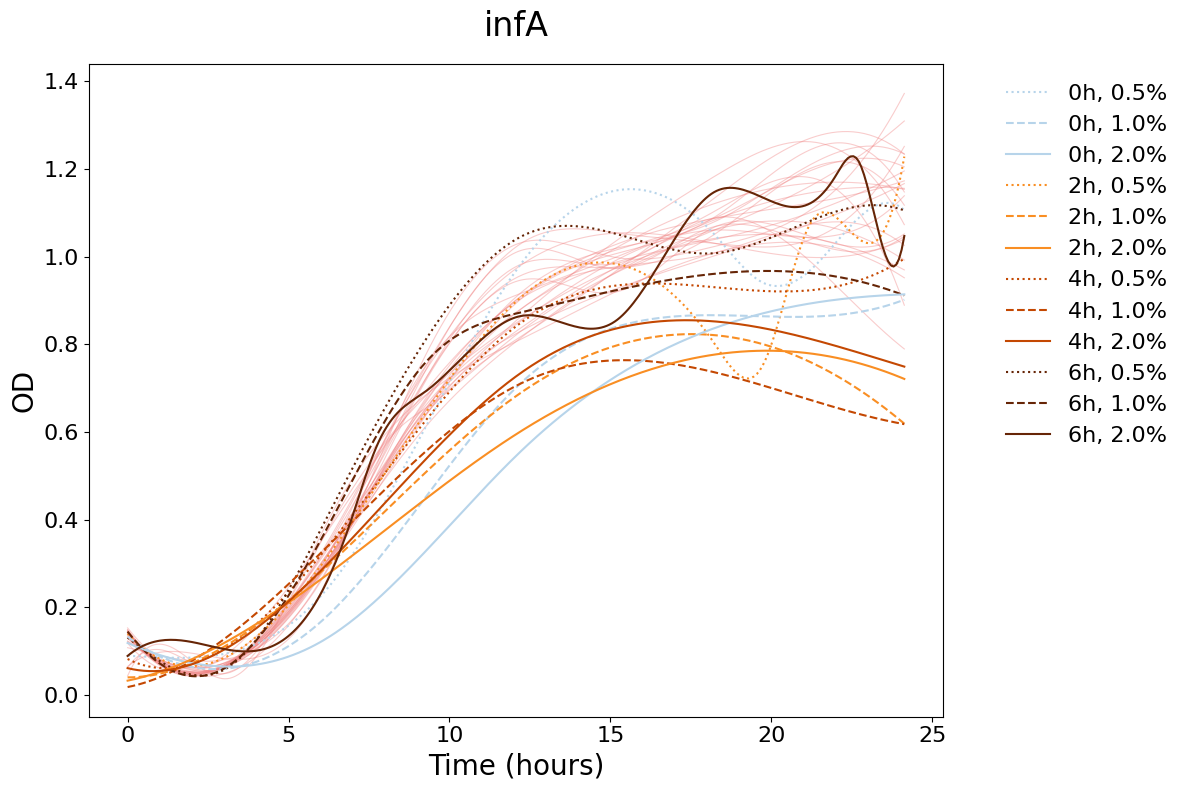

Saved plot as: Strain_name_BEC01430_Gene_target_rpoA.svg


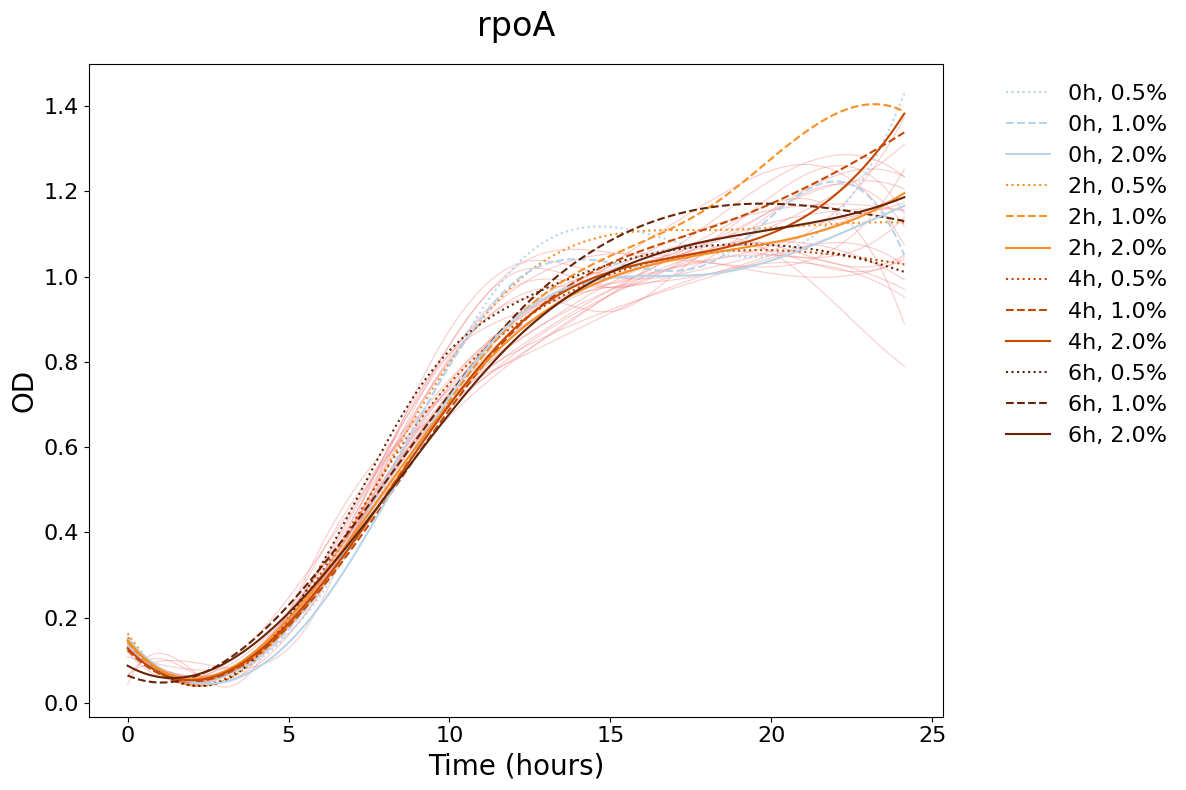

Saved plot as: Strain_name_BEC24310_Gene_target_folD.svg


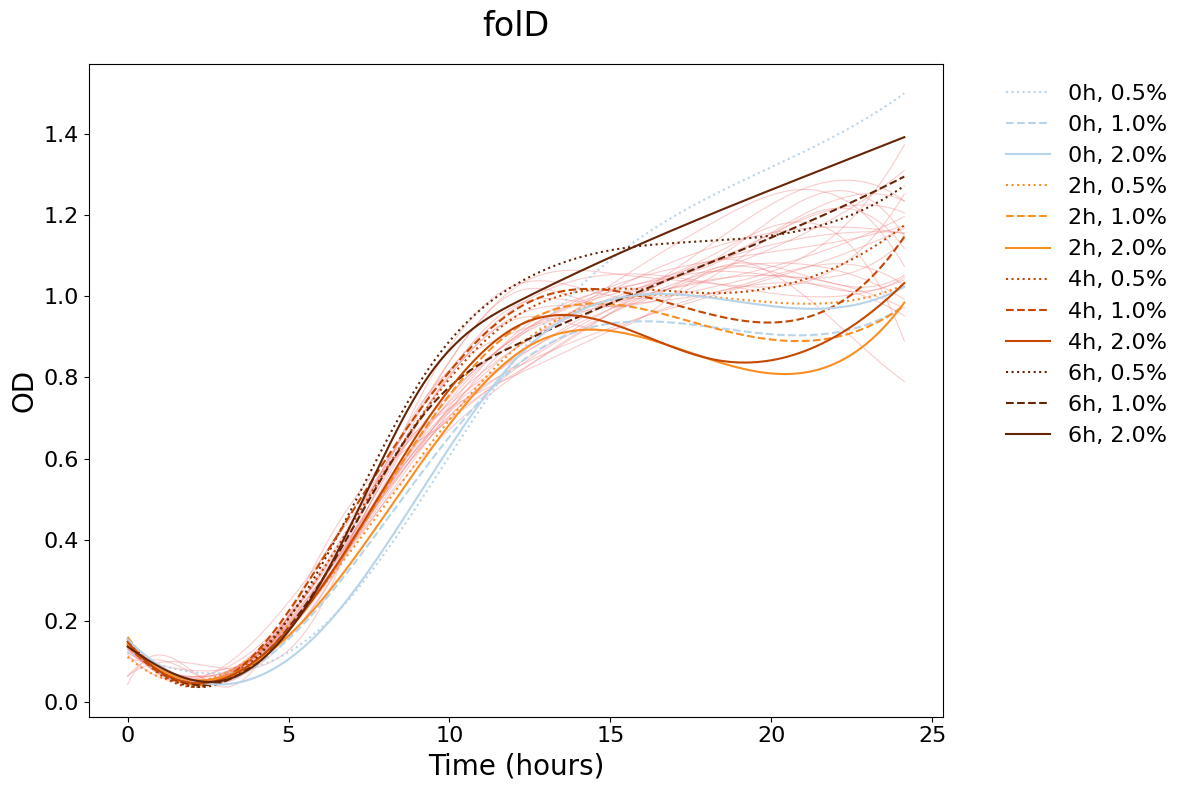

Saved plot as: Strain_name_BEC29660_Gene_target_rpsD.svg


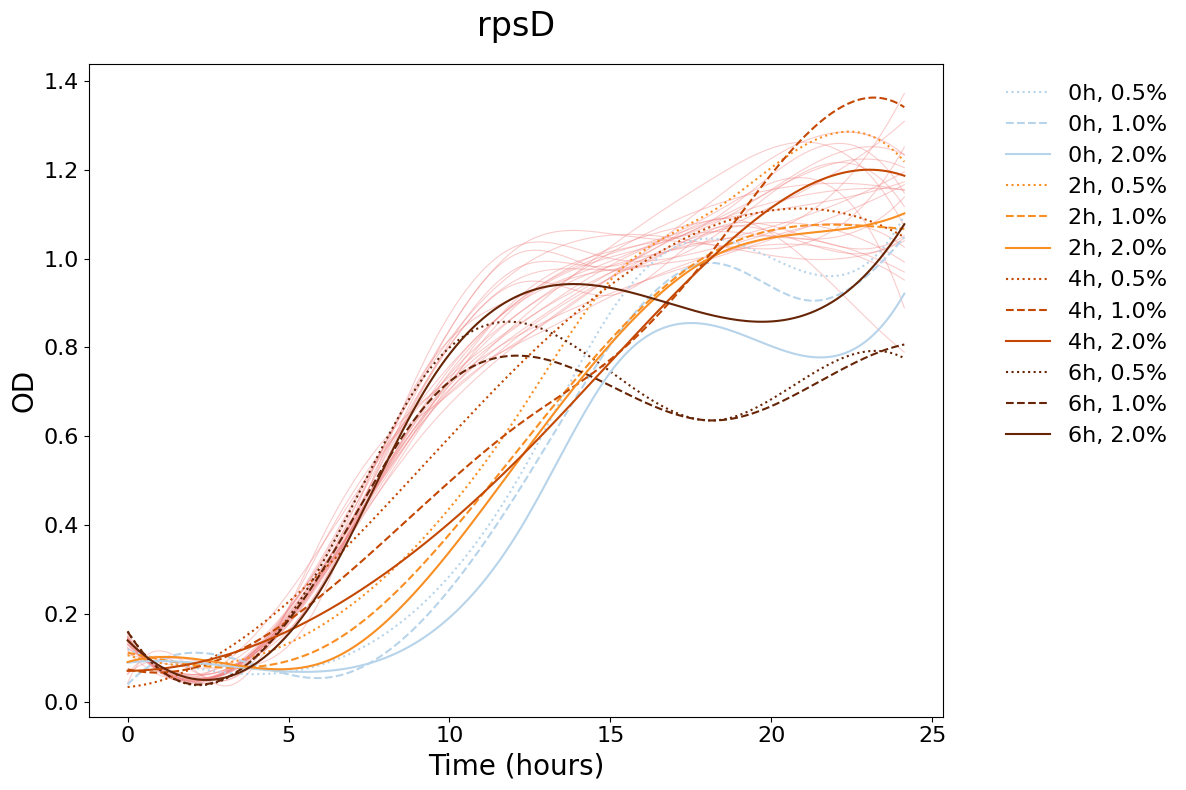

Saved plot as: Strain_name_BEC35760_Gene_target_tagB.svg


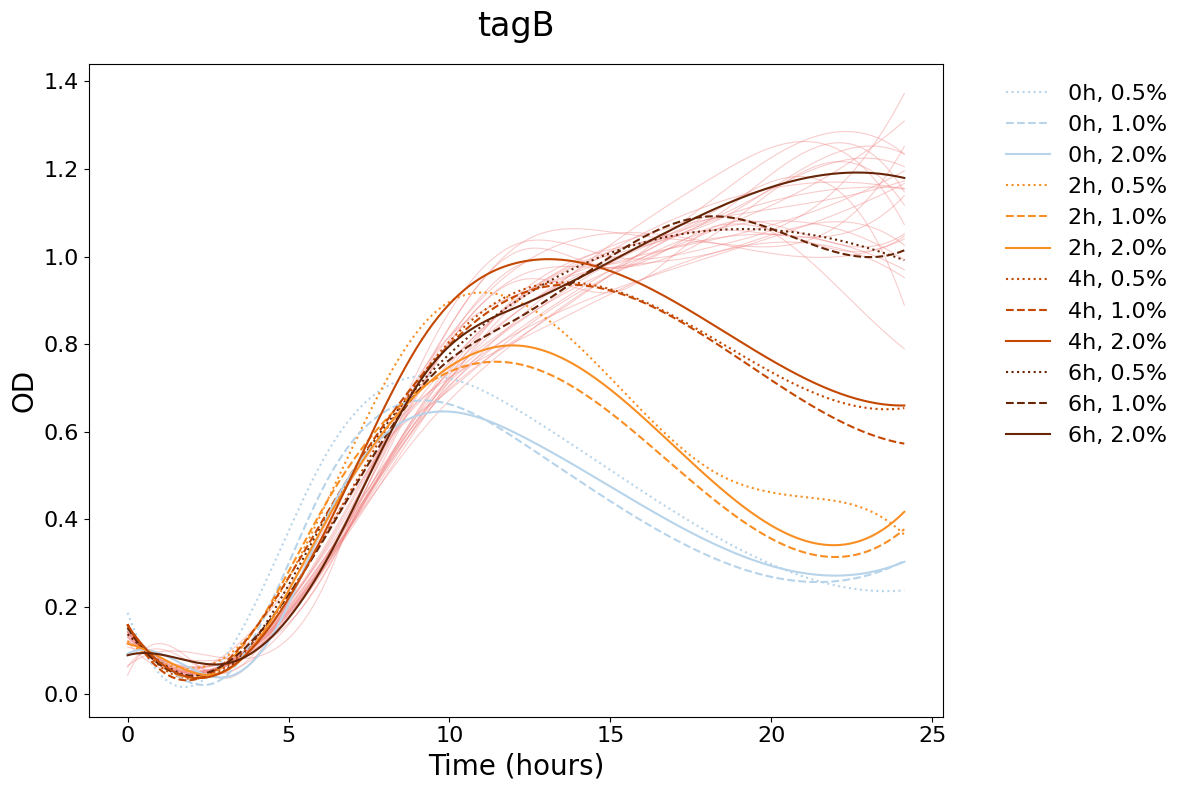

Saved plot as: Strain_name_BEC38120_Gene_target_rodA.svg


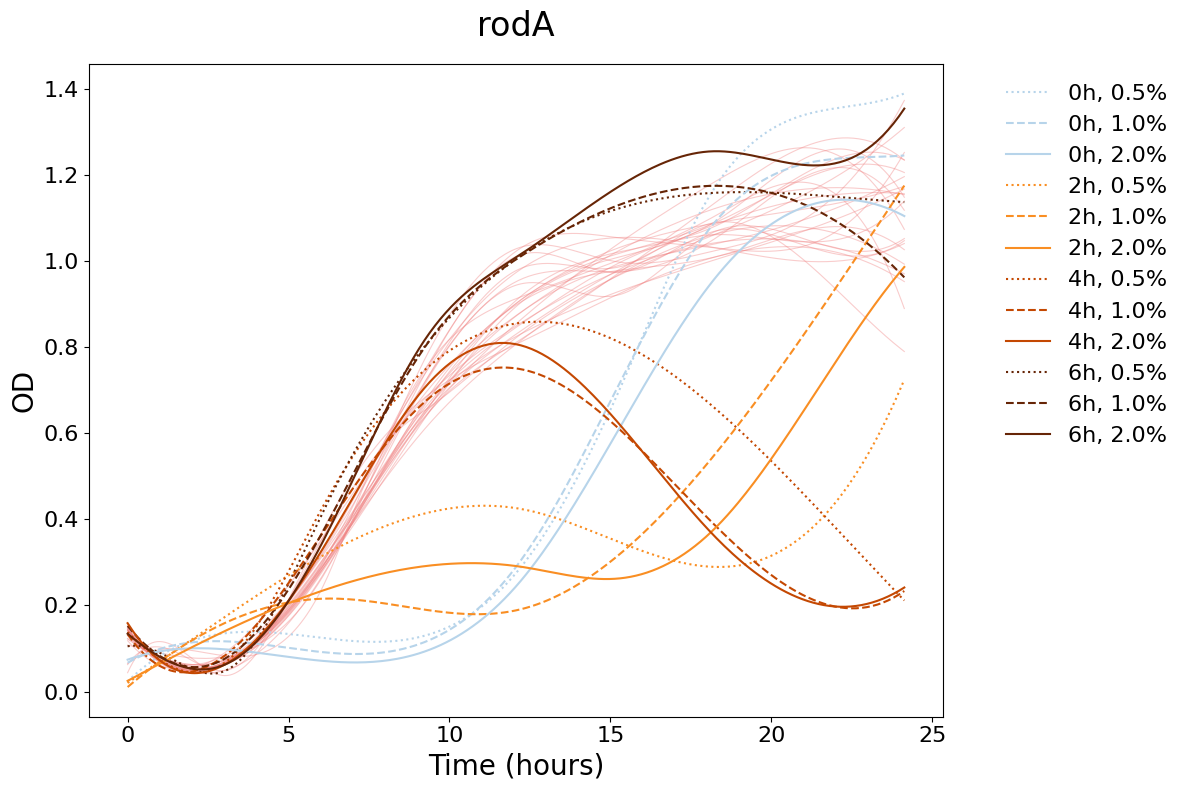

Saved plot as: Strain_name_CAG74399_72_Gene_target_no_sgRNA.svg


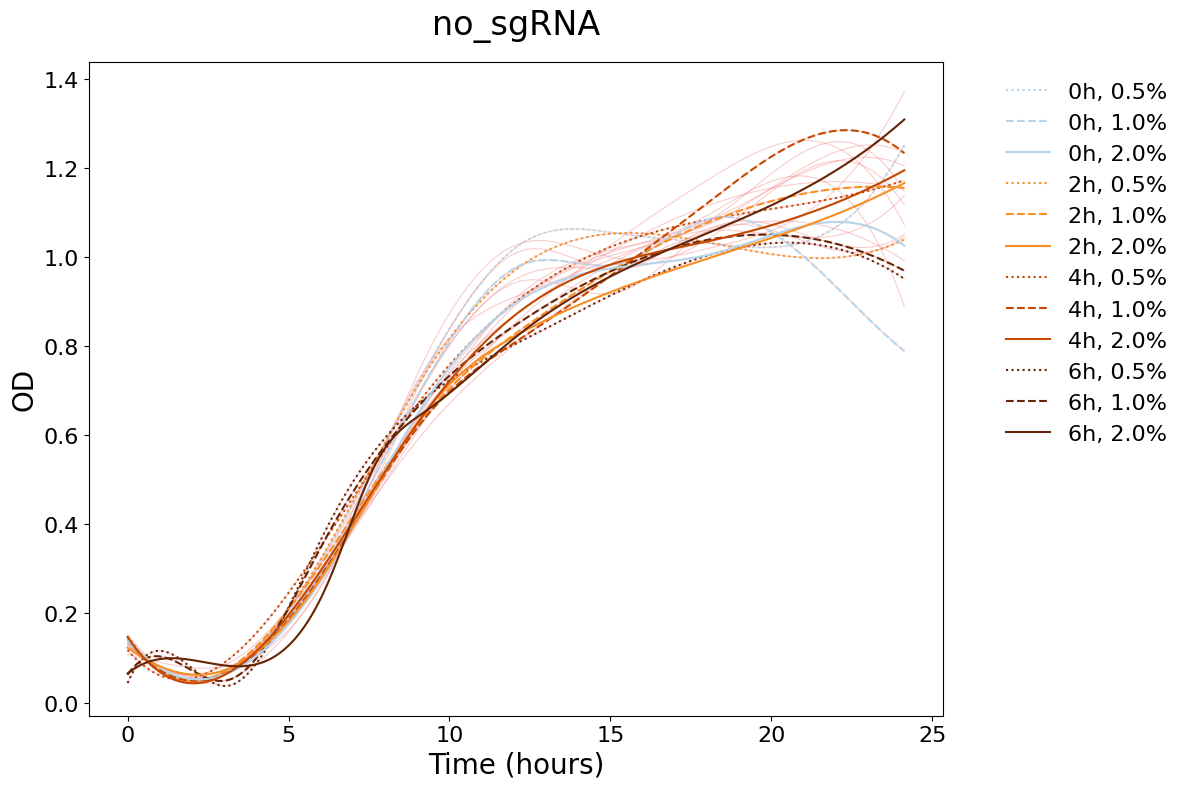

Saved plot as: Strain_name_CAG74399_84_Gene_target_no_sgRNA.svg


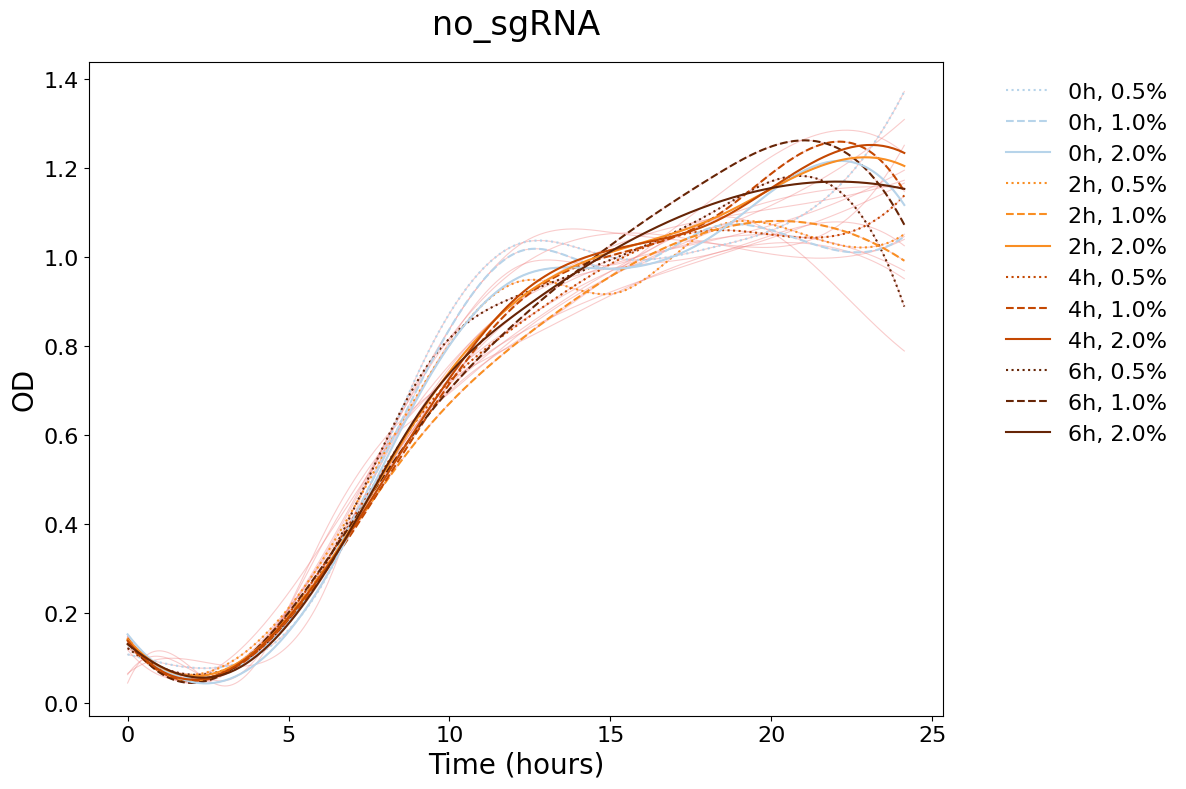

In [14]:
#fontx2
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
import numpy as np
import re

# --- PREPROCESSING ---
# Extract strain name
df_smoothed["Strain"] = df_smoothed["Sample"]

# Convert xylose concentration to % string
df_smoothed["xylose_perc"] = (df_smoothed["MetaData_xyloseconc"] * 100).round(3).astype(str) + "%"

# Convert induction hour (e.g. "0u" → 0 as int)
df_smoothed["induction_h"] = df_smoothed["MetaData_xylosehour"].str.replace("u", "").astype(int)

# Extract reference subset (no_sgRNA)
df_ref = df_smoothed[df_smoothed["Sample"].str.contains("no_sgRNA", case=False, na=False)]

# --- STYLE DEFINITIONS ---
line_styles = {
    "0.5%": ":",
    "1.0%": "--",
    "2.0%": "-"
}

unique_times = sorted(df_smoothed["induction_h"].unique())
cmap_blue = get_cmap("Blues")
cmap_yellow = get_cmap("YlOrBr")

# Assign colors per induction hour
cmap_dict = {}
for i, t in enumerate(unique_times):
    if t == 0:
        cmap_dict[t] = cmap_blue(np.linspace(0.3, 1, len(unique_times)))[i]
    else:
        cmap_dict[t] = cmap_yellow(np.linspace(0.3, 1, len(unique_times)))[i]

# --- PLOTTING ---
for strain, strain_df in df_smoothed.groupby("Strain"):
    # Increased figsize to 12x8 to accommodate larger font sizes
    fig, ax = plt.subplots(figsize=(12, 8)) 
    
    # Plot reference wells
    if not df_ref.empty:
        for well, ref_group in df_ref.groupby("Well"):
            ax.plot(
                ref_group["Time"],
                ref_group["Smoothed_OD"],
                color="lightcoral",
                linestyle="-",
                linewidth=0.8,
                alpha=0.4
            )
    
    # Plot actual strain curves
    for (xyl, ind), group in strain_df.groupby(["xylose_perc", "induction_h"]):
        linestyle = line_styles.get(xyl, "-")
        color = cmap_dict[ind]
        
        ax.plot(
            group["Time"],
            group["Smoothed_OD"],
            linestyle=linestyle,
            color=color,
            linewidth=1.5,
            label=f"{ind}h, {xyl}"
        )

    # --- TITLES AND LABELS (DOUBLED SIZES) ---
    gene_target = strain.split("Gene target: ")[1].strip()
    ax.set_title(f"{gene_target}", fontsize=24, pad=20)
    ax.set_xlabel("Time (hours)", fontsize=20)
    ax.set_ylabel("OD", fontsize=20)

    # --- AXIS NUMBERS (TICKS) (DOUBLED SIZES) ---
    ax.tick_params(axis='both', which='major', labelsize=16)

    # --- REORDER LEGEND ---
    handles, labels = ax.get_legend_handles_labels()

    def parse_label(lbl):
        # Splits on comma and handles potential spaces
        parts = lbl.split(",")
        ind = int(parts[0].replace("h", "").strip())
        xyl = float(parts[1].replace("%", "").strip())
        return ind, xyl

    sorted_pairs = sorted(zip(handles, labels), key=lambda hl: parse_label(hl[1]))
    handles_sorted, labels_sorted = zip(*sorted_pairs)

    # --- LEGEND FONT (DOUBLED SIZE) ---
    ax.legend(handles_sorted, labels_sorted,
              bbox_to_anchor=(1.05, 1),
              loc="upper left",
              frameon=False,
              fontsize=16) 

    plt.tight_layout()

    # --- SAVE FIGURE ---
    # safe filename logic
    safe_strain = re.sub(r"[^A-Za-z0-9_-]+", "_", strain)
    filename = f"{safe_strain}.svg"
    
    # Use bbox_inches="tight" to ensure the legend is included in the file
    plt.savefig(filename, format="svg", bbox_inches="tight")
    print(f"Saved plot as: {filename}")

    plt.show()

Saved plot as: infA.svg


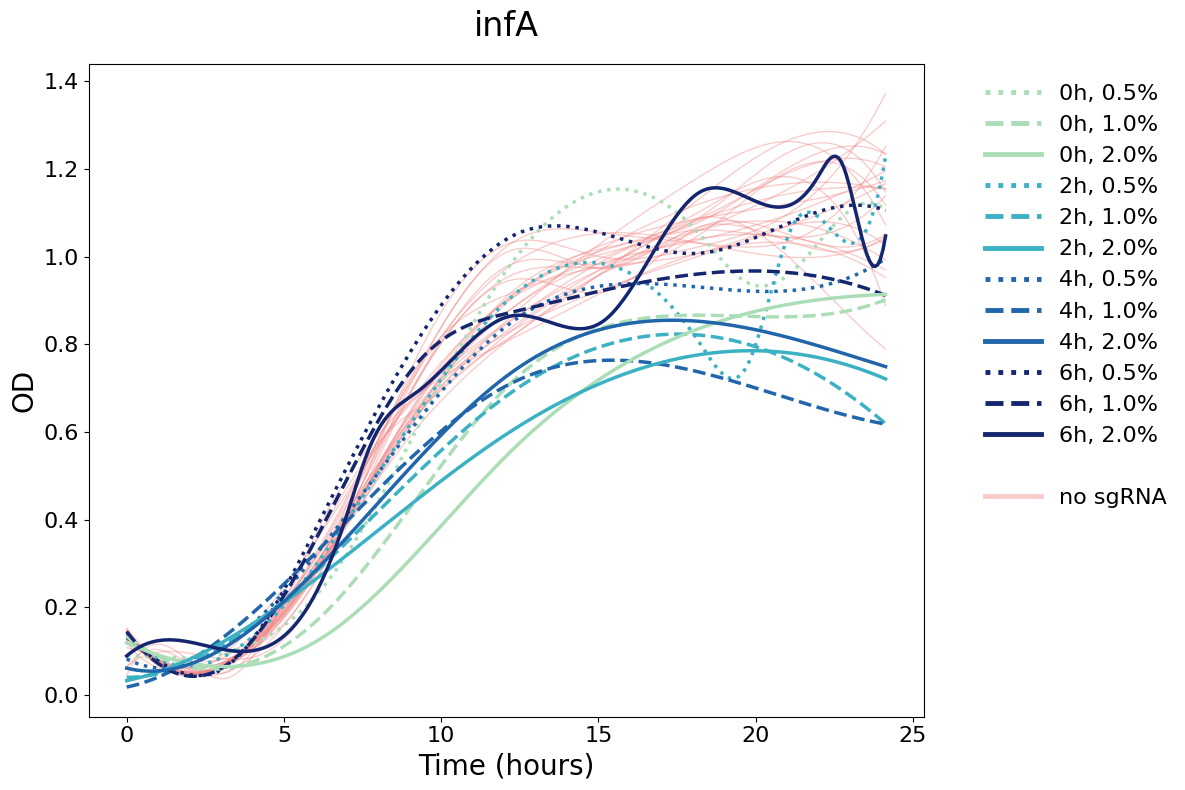

Saved plot as: rpoA.svg


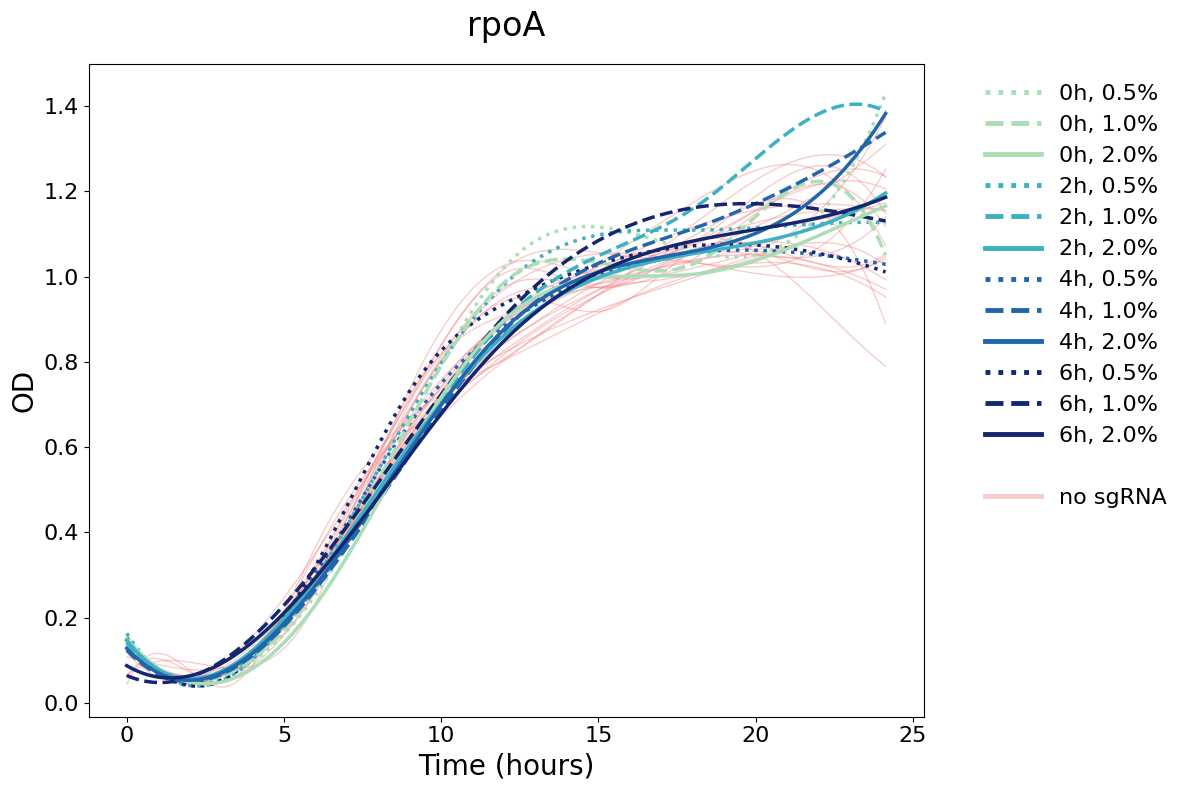

Saved plot as: folD.svg


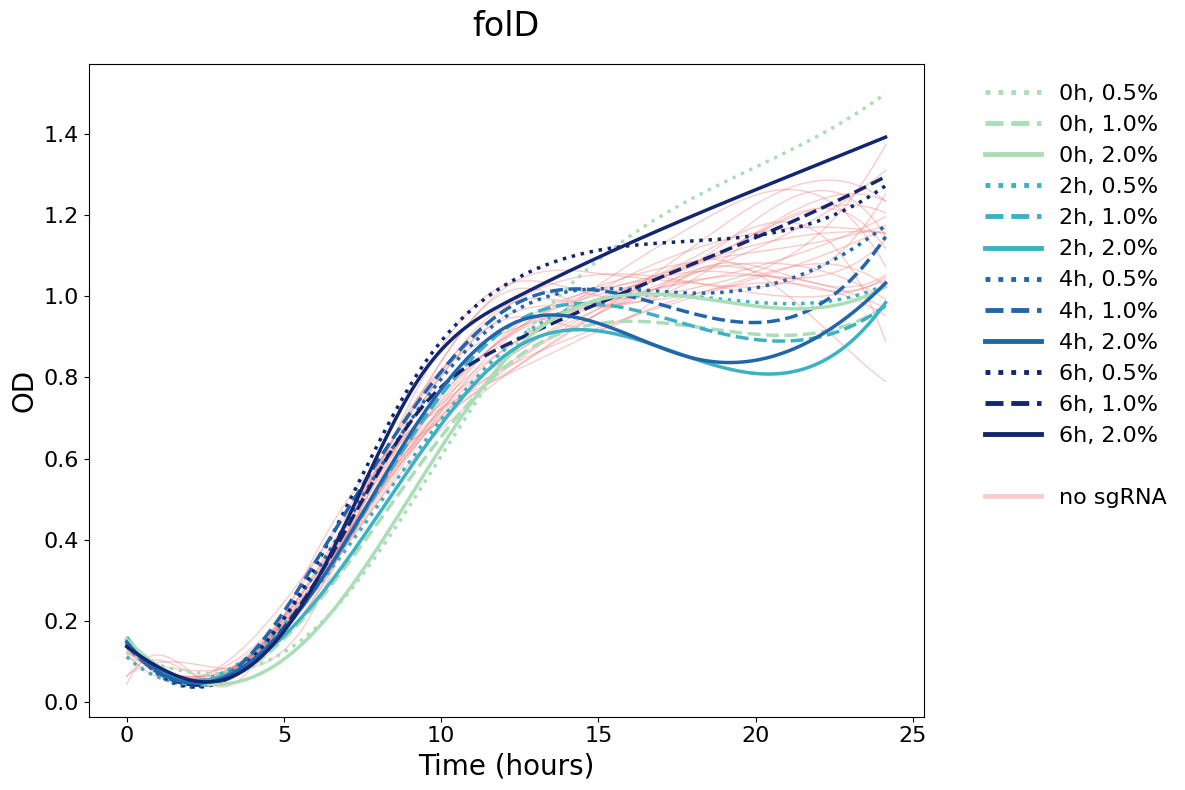

Saved plot as: rpsD.svg


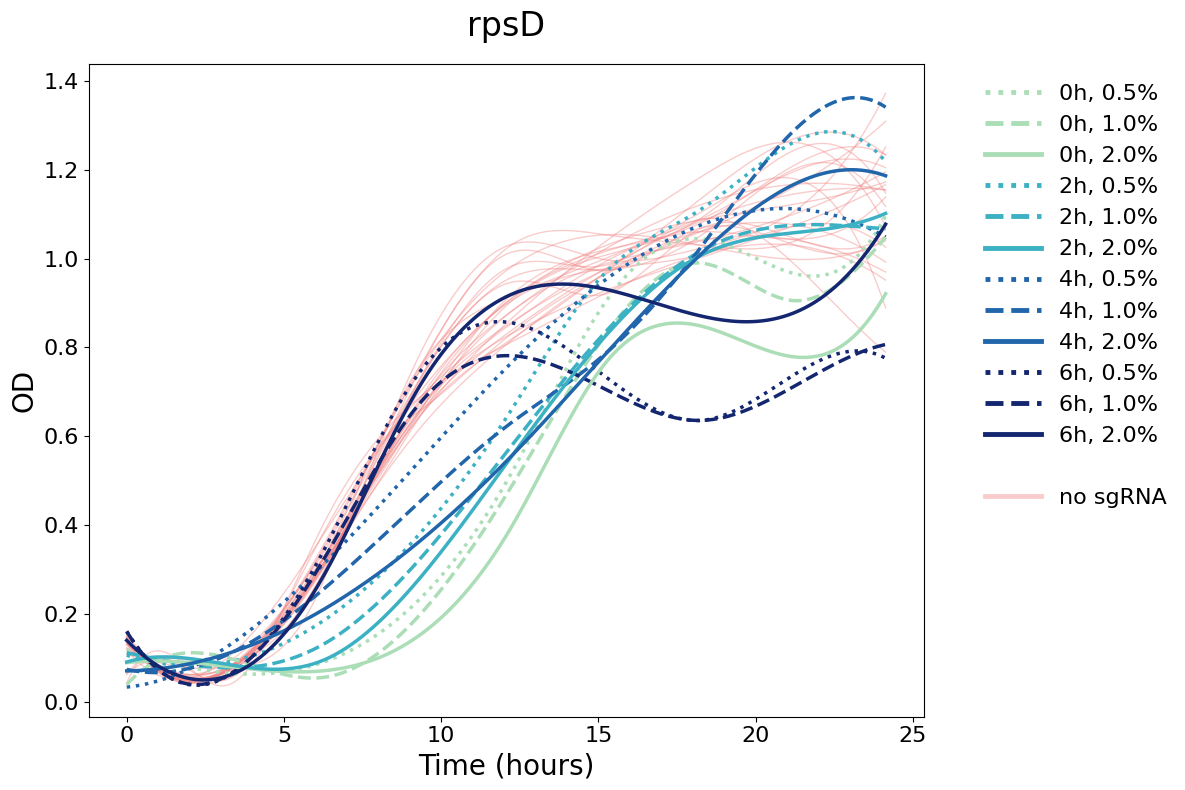

Saved plot as: tagB.svg


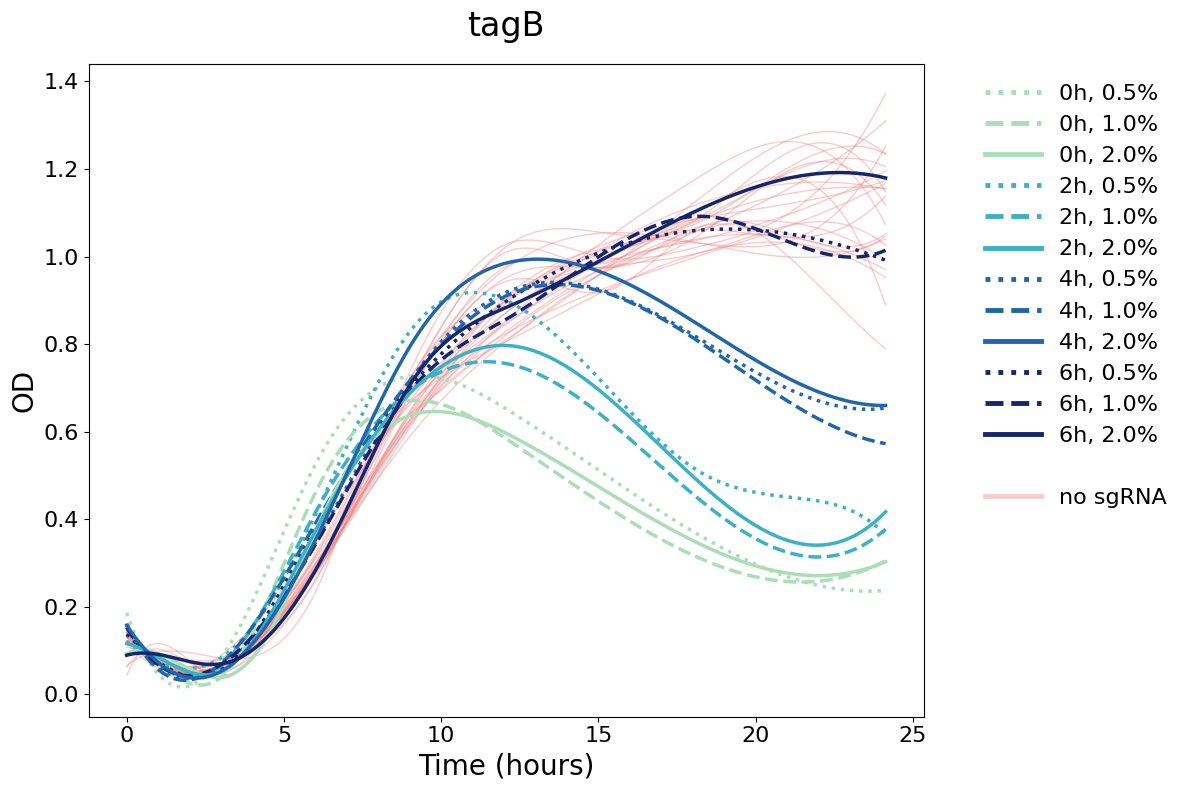

Saved plot as: rodA.svg


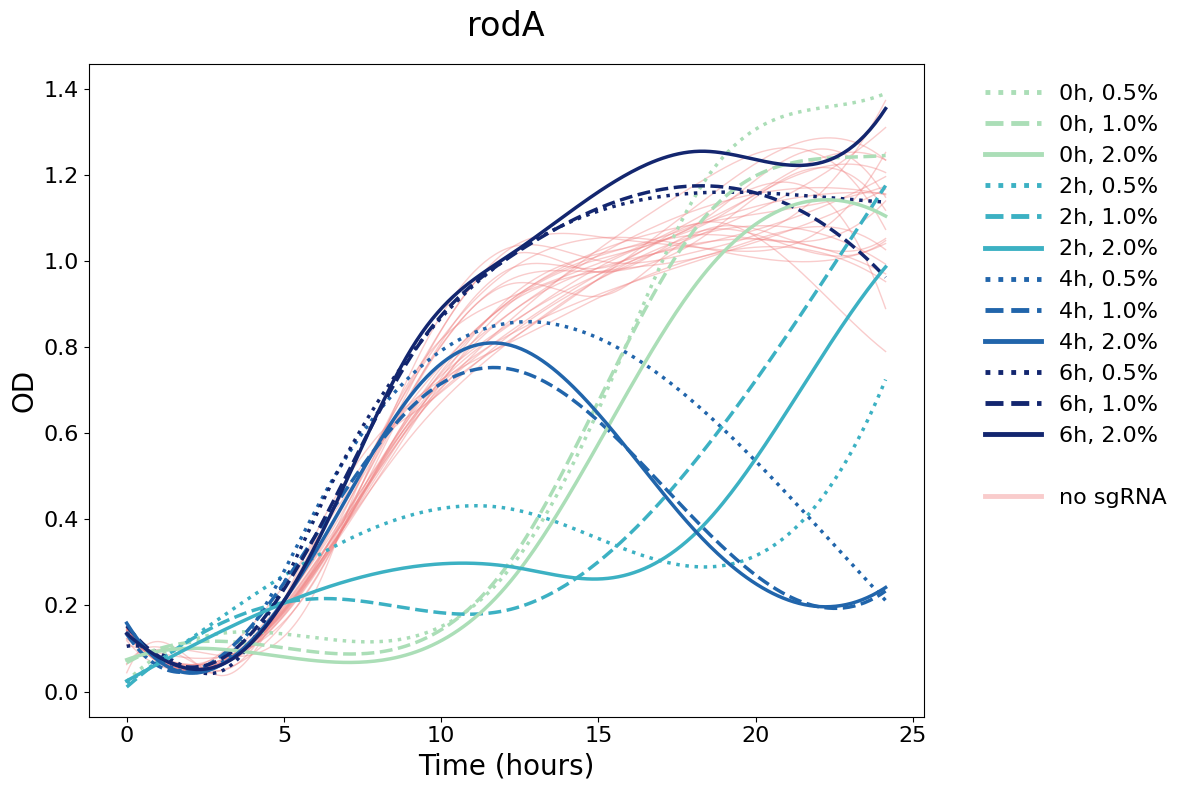

Saved plot as: no_sgRNA.svg


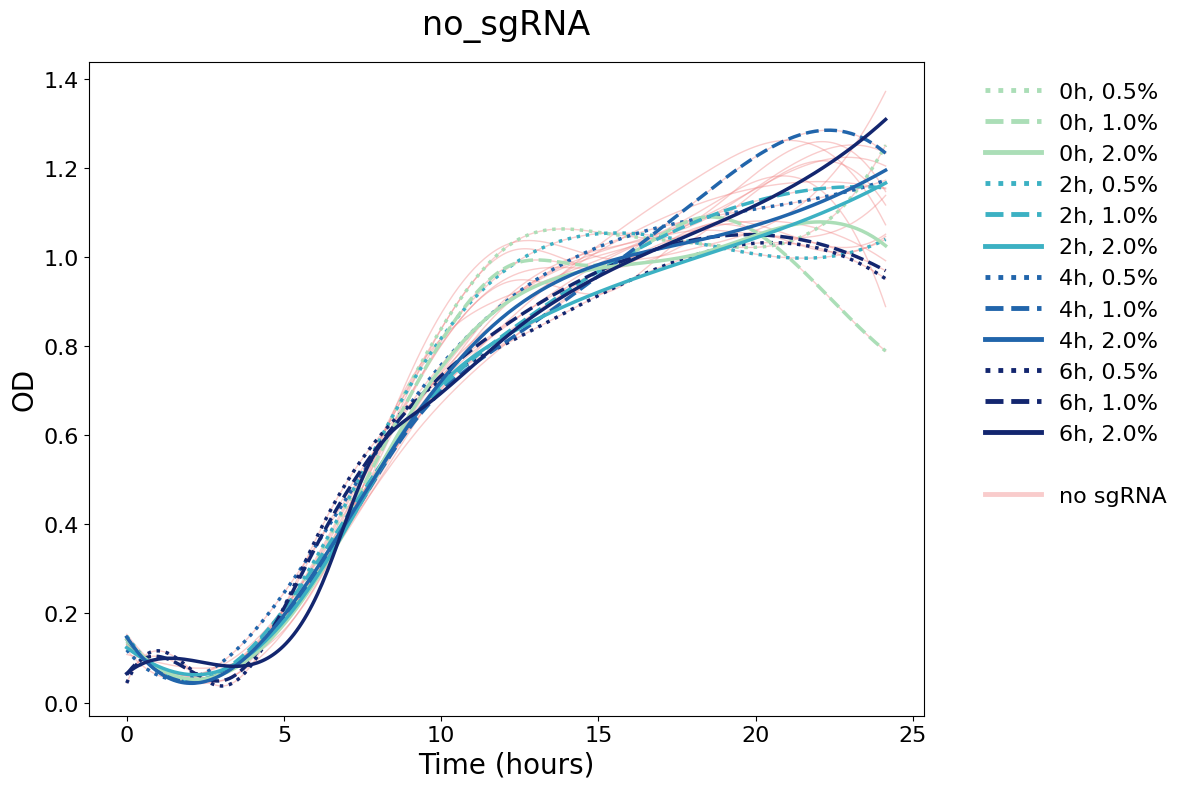

Saved plot as: no_sgRNA.svg


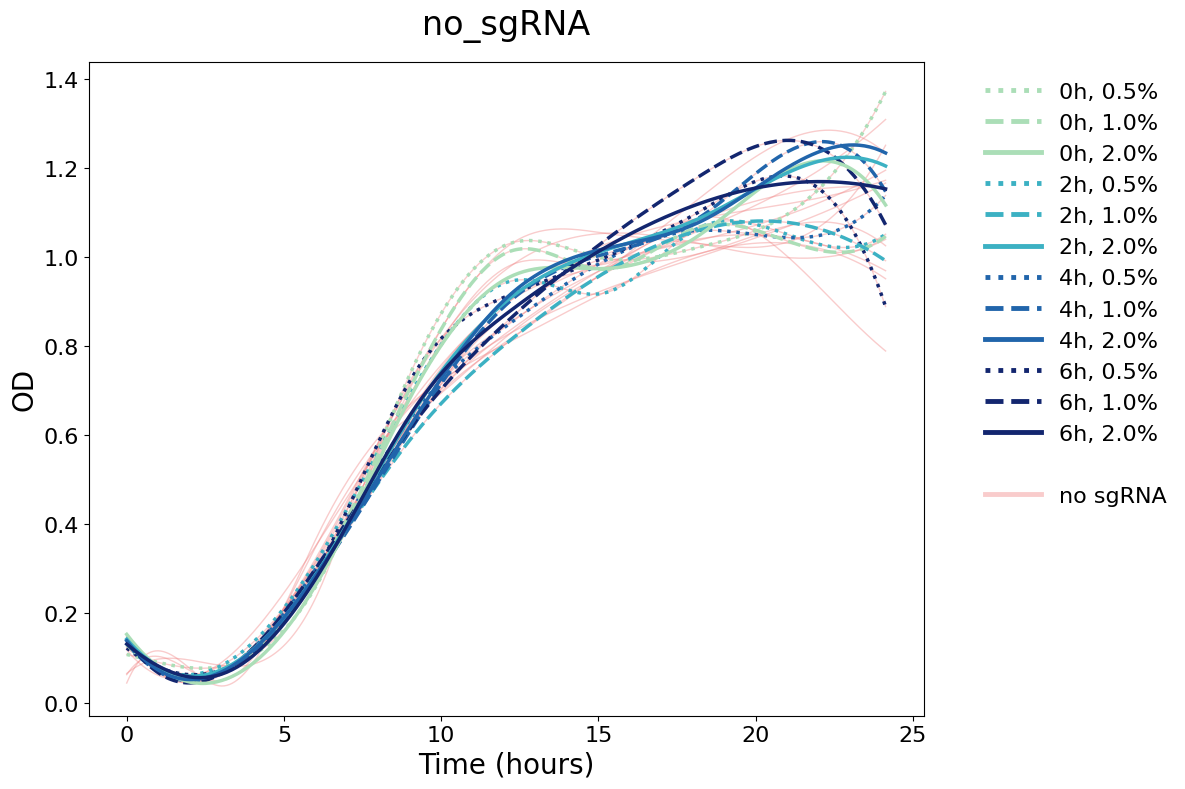

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from matplotlib.lines import Line2D

# --- PREPROCESSING ---
df_smoothed["Strain"] = df_smoothed["Sample"]
df_smoothed["xylose_perc"] = (df_smoothed["MetaData_xyloseconc"] * 100).round(3).astype(str) + "%"
df_smoothed["induction_h"] = df_smoothed["MetaData_xylosehour"].str.replace("u", "").astype(int)

# Extract reference subset
df_ref = df_smoothed[df_smoothed["Sample"].str.contains("no_sgRNA", case=False, na=False)]

# --- STYLE DEFINITIONS ---
line_styles = {
    "0.5%": ":",
    "1.0%": "--",
    "2.0%": "-"
}

# --- SCIENTIFIC COLOR GRADIENT (Light to Dark) ---
unique_times = sorted(df_smoothed["induction_h"].unique())
num_times = len(unique_times)

# YlGnBu transitions from light (0h) to dark (last hour)
# Using 0.3 to 0.95 range for professional visibility
colors = plt.cm.YlGnBu(np.linspace(0.3, 0.95, num_times))
cmap_dict = {t: colors[i] for i, t in enumerate(unique_times)}

# --- PLOTTING ---
for strain, strain_df in df_smoothed.groupby("Strain"):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # 1. Plot reference wells (no_sgRNA)
    ref_handle = None
    if not df_ref.empty:
        for i, (well, ref_group) in enumerate(df_ref.groupby("Well")):
            line, = ax.plot(
                ref_group["Time"],
                ref_group["Smoothed_OD"],
                color="lightcoral", 
                linestyle="-",
                linewidth=1.0,
                alpha=0.4
            )
            if i == 0:
                ref_handle = line 

    # 2. Plot actual strain curves
    for (xyl, ind), group in strain_df.groupby(["xylose_perc", "induction_h"]):
        linestyle = line_styles.get(xyl, "-")
        color = cmap_dict[ind]
        
        ax.plot(
            group["Time"],
            group["Smoothed_OD"],
            linestyle=linestyle,
            color=color,
            linewidth=2.5,
            label=f"{ind}h, {xyl}"
        )

    # --- TITLES AND LABELS (DOUBLED SIZES) ---
    gene_target = strain.split("Gene target: ")[1].strip()
    title_text = f"{gene_target}"
    
    ax.set_title(title_text, fontsize=24, pad=20)
    ax.set_xlabel("Time (hours)", fontsize=20)
    ax.set_ylabel("OD", fontsize=20)

    # --- AXIS NUMBERS (TICKS) ---
    ax.tick_params(axis='both', which='major', labelsize=16)

    # --- CUSTOM LEGEND ORDERING ---
    handles, labels = ax.get_legend_handles_labels()

    def parse_label(lbl):
        try:
            parts = lbl.split(",")
            ind = int(parts[0].replace("h", "").strip())
            xyl = float(parts[1].replace("%", "").strip())
            return (ind, xyl)
        except:
            return (999, 999)

    # Filter out reference for initial sort
    main_entries = [(h, l) for h, l in zip(handles, labels) if "no_sgRNA" not in l]
    main_entries_sorted = sorted(main_entries, key=lambda x: parse_label(x[1]))
    
    final_handles, final_labels = zip(*main_entries_sorted)
    final_handles = list(final_handles)
    final_labels = list(final_labels)

    # Add space and move no_sgRNA to the end
    if ref_handle:
        # Ghost handle for empty space
        final_handles.append(Line2D([0], [0], color='white', alpha=0))
        final_labels.append("") 
        
        final_handles.append(ref_handle)
        final_labels.append("no sgRNA")

    # --- LEGEND STYLING ---
    leg = ax.legend(final_handles, final_labels,
                    bbox_to_anchor=(1.05, 1),
                    loc="upper left",
                    frameon=False,
                    fontsize=16,
                    handlelength=2.5) 

    # Make legend symbols thicker for better visibility
    for line in leg.get_lines():
        line.set_linewidth(3.5)

    plt.tight_layout()

    # --- SAVE FIGURE ---
    # Saving based on your title logic
    filename = f"{title_text.replace(' ', '_')}.svg"
    plt.savefig(filename, format="svg", bbox_inches="tight")
    print(f"Saved plot as: {filename}")

    plt.show()